In [24]:
import sys
from __future__ import division, print_function, absolute_import
sys.path.append('/home/ajss/notebooks/deep-learning-projects/')
from sklearn.metrics import silhouette_samples, silhouette_score

from tqdm import tqdm
from rbm import RBM
from rbm_original import RBMOriginal
from au import AutoEncoder
from sklearn.cross_validation import train_test_split
import scic_stat_tests

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.cm as cm

import silhouette_plot  

import Image
from tensorflow.python.ops import control_flow_ops
from utils import tile_raster_images
import IPython.display
import math
%matplotlib inline


(42000, 784)
(42000,)


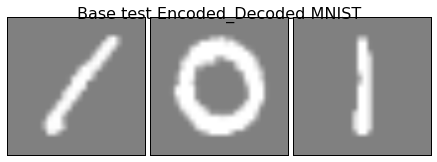

In [25]:
def next_batch(index,data,labels,batch_size=10):
    """Return the next `batch_size` examples from this data set."""
    total = data.shape[0]
    end = index + batch_size
    max_end =  max(0, index + batch_size - total)
    retData =  np.concatenate((data[index:end],data[:max_end]), axis=0)
    retlabel =  np.concatenate((labels[index:end],labels[:max_end]), axis=0)
    return retData,retlabel
def plot_gallery(title, images, n_col, n_row,image_shape = (28, 28)):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,            
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    plt.show()   
    
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

# read training data from CSV file 
dataTrain = pd.read_csv('./kaggle-mnist/train.csv')
images = dataTrain.iloc[:,1:].values
images = images.astype(np.float)
images = np.multiply(images, 1.0 / 255.0)

labels_flat = dataTrain[[0]].values.ravel()
labels_count = np.unique(labels_flat).shape[0]
# labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels_flat #dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)
print(images.shape)
print(labels.shape)
for i in range(1):
    batch_xs, batch_ys = next_batch(i*10, images,labels)
    plot_gallery('Base test Encoded_Decoded MNIST',batch_xs[:3],3,1)



In [3]:
# # read test data from CSV file 
# datatest = pd.read_csv('./kaggle-mnist/test.csv')
# imagestest = datatest.iloc[:,:].values
# imagestest = imagestest.astype(np.float)
# imagestest = np.multiply(imagestest, 1.0 / 255.0)


dA - Pre treino
---------

In [4]:

flags = tf.app.flags
FLAGS = flags.FLAGS
#flags.DEFINE_string('data_dir', '/home/ajsss/data_deep/', 'Directory for storing data')


In [5]:
from da import DenoisingAutoencoder

keep_prob_value = 1
# First dA
da1 = DenoisingAutoencoder(784, 1000, ['daw1', 'davb1', 'dahb1'],0.3,keep_prob=keep_prob_value)
epoch = 50
batch_size =30
interactions = int(math.floor(images.shape[0]/batch_size))
for i in tqdm(range(epoch)):
    for j in range(interactions):
        batch_xs, batch_ys = next_batch(j*batch_size, images,labels,batch_size)
        cost = da1.partial_fit(batch_xs)
    print(da1.compute_cost(images))
da1.save_weights('./data-models/da1.chp')
# Second dA
da2 = DenoisingAutoencoder(1000, 500, ['daw2', 'davb2', 'dahb2'], 0.3,keep_prob=keep_prob_value)
for i in tqdm(range(epoch)):
    for j in range(interactions):
        # Transform features with first rbm for second rbm
        batch_xs, batch_ys = next_batch(j*batch_size, images,labels,batch_size)
        batch_xs = da1.transform(batch_xs)
        cost = da2.partial_fit(batch_xs)
    print(da2.compute_cost(da1.transform(images)))

da2.save_weights('./data-models/da2.chp')
# third dA
da3 = DenoisingAutoencoder(500, 250, ['daw3', 'davb3', 'dahb3'], 0.3,keep_prob=keep_prob_value)
for i in tqdm(range(epoch)):
    for j in range(interactions):
        # Transform features with first rbm for second rbm
        batch_xs, batch_ys = next_batch(j*batch_size, images,labels,batch_size)
        batch_xs = da1.transform(batch_xs)
        batch_xs = da2.transform(batch_xs)
        cost = da3.partial_fit(batch_xs)
    print(da3.compute_cost(da2.transform(da1.transform(images))))

da3.save_weights('./data-models/da3.chp')
# 4th dA
da4 = DenoisingAutoencoder(250, 2, ['daw4', 'davb4', 'dahb4'], 0.3,keep_prob=keep_prob_value)
for i in tqdm(range(epoch)):
    for j in range(interactions):
        # Transform features with first rbm for second rbm
        batch_xs, batch_ys = next_batch(j*batch_size, images,labels,batch_size)
        batch_xs = da1.transform(batch_xs)
        batch_xs = da2.transform(batch_xs)
        batch_xs = da3.transform(batch_xs)
        cost = da4.partial_fit(batch_xs)
    print(da4.compute_cost(da3.transform(da2.transform(da1.transform(images)))))

da4.save_weights('./data-models/da4.chp')


  2%|▏         | 1/50 [00:08<06:33,  8.03s/it]

0.228875


  4%|▍         | 2/50 [00:15<06:22,  7.97s/it]

0.205283


  6%|▌         | 3/50 [00:23<06:15,  7.99s/it]

0.188387


  8%|▊         | 4/50 [00:31<06:07,  7.99s/it]

0.176356


 10%|█         | 5/50 [00:39<05:59,  7.99s/it]

0.166979


 12%|█▏        | 6/50 [00:47<05:51,  8.00s/it]

0.159194


 14%|█▍        | 7/50 [00:55<05:43,  8.00s/it]

0.152505


 16%|█▌        | 8/50 [01:03<05:35,  7.99s/it]

0.146645


 18%|█▊        | 9/50 [01:11<05:27,  7.98s/it]

0.141448


 20%|██        | 10/50 [01:19<05:19,  7.98s/it]

0.136796


 22%|██▏       | 11/50 [01:27<05:11,  7.98s/it]

0.132596


 24%|██▍       | 12/50 [01:35<05:03,  7.99s/it]

0.128775


 26%|██▌       | 13/50 [01:43<04:55,  7.98s/it]

0.125278


 28%|██▊       | 14/50 [01:51<04:47,  7.98s/it]

0.122062


 30%|███       | 15/50 [01:59<04:39,  7.98s/it]

0.119092


 32%|███▏      | 16/50 [02:07<04:31,  7.98s/it]

0.116341


 34%|███▍      | 17/50 [02:15<04:23,  7.99s/it]

0.113783


 36%|███▌      | 18/50 [02:23<04:15,  7.99s/it]

0.111399


 38%|███▊      | 19/50 [02:31<04:07,  7.98s/it]

0.10917


 40%|████      | 20/50 [02:39<03:59,  7.98s/it]

0.107079


 42%|████▏     | 21/50 [02:47<03:51,  7.99s/it]

0.105114


 44%|████▍     | 22/50 [02:55<03:43,  7.99s/it]

0.103262


 46%|████▌     | 23/50 [03:03<03:34,  7.95s/it]

0.101514


 48%|████▊     | 24/50 [03:11<03:27,  7.98s/it]

0.0998598


 50%|█████     | 25/50 [03:19<03:19,  7.99s/it]

0.0982922


 52%|█████▏    | 26/50 [03:27<03:11,  8.00s/it]

0.0968038


 54%|█████▍    | 27/50 [03:35<03:03,  7.99s/it]

0.095388


 56%|█████▌    | 28/50 [03:43<02:55,  7.99s/it]

0.094039


 58%|█████▊    | 29/50 [03:51<02:47,  7.99s/it]

0.0927513


 60%|██████    | 30/50 [03:59<02:39,  7.99s/it]

0.0915204


 62%|██████▏   | 31/50 [04:07<02:31,  7.99s/it]

0.0903419


 64%|██████▍   | 32/50 [04:15<02:23,  7.99s/it]

0.089212


 66%|██████▌   | 33/50 [04:23<02:15,  7.99s/it]

0.0881273


 68%|██████▊   | 34/50 [04:31<02:07,  7.99s/it]

0.0870847


 70%|███████   | 35/50 [04:39<01:59,  7.99s/it]

0.0860813


 72%|███████▏  | 36/50 [04:47<01:51,  7.98s/it]

0.0851147


 74%|███████▍  | 37/50 [04:55<01:43,  7.99s/it]

0.0841826


 76%|███████▌  | 38/50 [05:03<01:35,  8.00s/it]

0.0832828


 78%|███████▊  | 39/50 [05:11<01:28,  8.00s/it]

0.0824134


 80%|████████  | 40/50 [05:19<01:20,  8.00s/it]

0.0815729


 82%|████████▏ | 41/50 [05:27<01:12,  8.01s/it]

0.0807591


 84%|████████▍ | 42/50 [05:35<01:04,  8.00s/it]

0.0799713


 86%|████████▌ | 43/50 [05:43<00:55,  7.97s/it]

0.0792074


 88%|████████▊ | 44/50 [05:51<00:47,  7.98s/it]

0.0784668


 90%|█████████ | 45/50 [05:59<00:39,  7.99s/it]

0.0777479


 92%|█████████▏| 46/50 [06:07<00:32,  8.01s/it]

0.0770499


 94%|█████████▍| 47/50 [06:15<00:24,  8.00s/it]

0.0763716


 96%|█████████▌| 48/50 [06:23<00:16,  8.01s/it]

0.0757122


 98%|█████████▊| 49/50 [06:31<00:08,  8.01s/it]

0.0750706


100%|██████████| 50/50 [06:39<00:00,  8.00s/it]

0.0744461



  2%|▏         | 1/50 [00:08<07:08,  8.74s/it]

0.211393


  4%|▍         | 2/50 [00:17<06:58,  8.71s/it]

0.189329


  6%|▌         | 3/50 [00:25<06:47,  8.67s/it]

0.171845


  8%|▊         | 4/50 [00:34<06:37,  8.65s/it]

0.159304


 10%|█         | 5/50 [00:43<06:28,  8.63s/it]

0.149174


 12%|█▏        | 6/50 [00:51<06:19,  8.63s/it]

0.140272


 14%|█▍        | 7/50 [01:00<06:10,  8.62s/it]

0.132279


 16%|█▌        | 8/50 [01:08<06:01,  8.61s/it]

0.125059


 18%|█▊        | 9/50 [01:17<05:52,  8.61s/it]

0.118498


 20%|██        | 10/50 [01:26<05:43,  8.60s/it]

0.112512


 22%|██▏       | 11/50 [01:34<05:34,  8.59s/it]

0.107038


 24%|██▍       | 12/50 [01:43<05:25,  8.56s/it]

0.10202


 26%|██▌       | 13/50 [01:51<05:17,  8.58s/it]

0.097412


 28%|██▊       | 14/50 [02:00<05:08,  8.58s/it]

0.0931839


 30%|███       | 15/50 [02:08<05:00,  8.58s/it]

0.0893112


 32%|███▏      | 16/50 [02:17<04:52,  8.59s/it]

0.0857707


 34%|███▍      | 17/50 [02:26<04:43,  8.59s/it]

0.0825367


 36%|███▌      | 18/50 [02:34<04:35,  8.60s/it]

0.0795804


 38%|███▊      | 19/50 [02:43<04:26,  8.60s/it]

0.0768724


 40%|████      | 20/50 [02:51<04:17,  8.59s/it]

0.0743854


 42%|████▏     | 21/50 [03:00<04:09,  8.60s/it]

0.0720942


 44%|████▍     | 22/50 [03:09<04:00,  8.61s/it]

0.0699782


 46%|████▌     | 23/50 [03:17<03:52,  8.60s/it]

0.06802


 48%|████▊     | 24/50 [03:26<03:43,  8.61s/it]

0.0662054


 50%|█████     | 25/50 [03:35<03:35,  8.63s/it]

0.0645238


 52%|█████▏    | 26/50 [03:43<03:26,  8.62s/it]

0.062966


 54%|█████▍    | 27/50 [03:52<03:18,  8.61s/it]

0.0615241


 56%|█████▌    | 28/50 [04:00<03:09,  8.60s/it]

0.0601913


 58%|█████▊    | 29/50 [04:09<03:00,  8.61s/it]

0.0589602


 60%|██████    | 30/50 [04:18<02:51,  8.59s/it]

0.0578238


 62%|██████▏   | 31/50 [04:26<02:43,  8.60s/it]

0.0567743


 64%|██████▍   | 32/50 [04:35<02:34,  8.59s/it]

0.0558037


 66%|██████▌   | 33/50 [04:43<02:25,  8.59s/it]

0.0549045


 68%|██████▊   | 34/50 [04:52<02:17,  8.60s/it]

0.0540693


 70%|███████   | 35/50 [05:01<02:08,  8.59s/it]

0.0532912


 72%|███████▏  | 36/50 [05:09<02:00,  8.60s/it]

0.0525643


 74%|███████▍  | 37/50 [05:18<01:51,  8.60s/it]

0.0518831


 76%|███████▌  | 38/50 [05:26<01:43,  8.60s/it]

0.0512429


 78%|███████▊  | 39/50 [05:35<01:34,  8.60s/it]

0.0506395


 80%|████████  | 40/50 [05:44<01:26,  8.61s/it]

0.0500696


 82%|████████▏ | 41/50 [05:52<01:17,  8.60s/it]

0.0495297


 84%|████████▍ | 42/50 [06:01<01:08,  8.60s/it]

0.0490173


 86%|████████▌ | 43/50 [06:09<01:00,  8.59s/it]

0.0485298


 88%|████████▊ | 44/50 [06:18<00:51,  8.58s/it]

0.0480649


 90%|█████████ | 45/50 [06:26<00:42,  8.59s/it]

0.0476205


 92%|█████████▏| 46/50 [06:35<00:34,  8.60s/it]

0.0471949


 94%|█████████▍| 47/50 [06:44<00:25,  8.60s/it]

0.0467868


 96%|█████████▌| 48/50 [06:52<00:17,  8.60s/it]

0.0463943


 98%|█████████▊| 49/50 [07:01<00:08,  8.59s/it]

0.0460164


100%|██████████| 50/50 [07:09<00:00,  8.59s/it]

0.045652



  2%|▏         | 1/50 [00:09<07:21,  9.00s/it]

0.265741


  4%|▍         | 2/50 [00:17<07:07,  8.91s/it]

0.233781


  6%|▌         | 3/50 [00:26<06:55,  8.84s/it]

0.211136


  8%|▊         | 4/50 [00:35<06:44,  8.79s/it]

0.19457


 10%|█         | 5/50 [00:43<06:34,  8.76s/it]

0.180771


 12%|█▏        | 6/50 [00:52<06:23,  8.73s/it]

0.168881


 14%|█▍        | 7/50 [01:01<06:14,  8.71s/it]

0.158509


 16%|█▌        | 8/50 [01:09<06:05,  8.71s/it]

0.149332


 18%|█▊        | 9/50 [01:18<05:56,  8.69s/it]

0.141115


 20%|██        | 10/50 [01:27<05:47,  8.70s/it]

0.133687


 22%|██▏       | 11/50 [01:35<05:38,  8.69s/it]

0.126934


 24%|██▍       | 12/50 [01:44<05:30,  8.69s/it]

0.120784


 26%|██▌       | 13/50 [01:53<05:21,  8.69s/it]

0.115187


 28%|██▊       | 14/50 [02:01<05:12,  8.67s/it]

0.110098


 30%|███       | 15/50 [02:10<05:03,  8.68s/it]

0.105473


 32%|███▏      | 16/50 [02:19<04:54,  8.67s/it]

0.101265


 34%|███▍      | 17/50 [02:27<04:46,  8.68s/it]

0.0974329


 36%|███▌      | 18/50 [02:36<04:37,  8.67s/it]

0.0939334


 38%|███▊      | 19/50 [02:45<04:28,  8.67s/it]

0.0907288


 40%|████      | 20/50 [02:53<04:20,  8.67s/it]

0.0877854


 42%|████▏     | 21/50 [03:02<04:11,  8.66s/it]

0.085074


 44%|████▍     | 22/50 [03:11<04:01,  8.64s/it]

0.0825716


 46%|████▌     | 23/50 [03:19<03:52,  8.61s/it]

0.0802603


 48%|████▊     | 24/50 [03:28<03:43,  8.58s/it]

0.0781268


 50%|█████     | 25/50 [03:36<03:34,  8.59s/it]

0.0761607


 52%|█████▏    | 26/50 [03:45<03:25,  8.58s/it]

0.0743531


 54%|█████▍    | 27/50 [03:53<03:17,  8.60s/it]

0.0726957


 56%|█████▌    | 28/50 [04:02<03:09,  8.60s/it]

0.0711796


 58%|█████▊    | 29/50 [04:11<03:00,  8.61s/it]

0.0697959


 60%|██████    | 30/50 [04:19<02:52,  8.60s/it]

0.0685346


 62%|██████▏   | 31/50 [04:28<02:43,  8.59s/it]

0.0673857


 64%|██████▍   | 32/50 [04:36<02:34,  8.59s/it]

0.0663387


 66%|██████▌   | 33/50 [04:45<02:25,  8.58s/it]

0.0653833


 68%|██████▊   | 34/50 [04:54<02:17,  8.58s/it]

0.0645102


 70%|███████   | 35/50 [05:02<02:08,  8.57s/it]

0.0637105


 72%|███████▏  | 36/50 [05:11<01:59,  8.56s/it]

0.0629762


 74%|███████▍  | 37/50 [05:19<01:51,  8.57s/it]

0.0623002


 76%|███████▌  | 38/50 [05:28<01:42,  8.56s/it]

0.0616767


 78%|███████▊  | 39/50 [05:36<01:34,  8.55s/it]

0.0611


 80%|████████  | 40/50 [05:45<01:25,  8.54s/it]

0.0605655


 82%|████████▏ | 41/50 [05:53<01:16,  8.54s/it]

0.060069


 84%|████████▍ | 42/50 [06:02<01:08,  8.56s/it]

0.0596067


 86%|████████▌ | 43/50 [06:11<01:00,  8.58s/it]

0.0591754


 88%|████████▊ | 44/50 [06:19<00:51,  8.57s/it]

0.0587718


 90%|█████████ | 45/50 [06:28<00:42,  8.56s/it]

0.0583934


 92%|█████████▏| 46/50 [06:36<00:34,  8.58s/it]

0.0580375


 94%|█████████▍| 47/50 [06:45<00:25,  8.57s/it]

0.0577021


 96%|█████████▌| 48/50 [06:53<00:17,  8.57s/it]

0.0573852


 98%|█████████▊| 49/50 [07:02<00:08,  8.57s/it]

0.0570849


100%|██████████| 50/50 [07:11<00:00,  8.58s/it]

0.0567996



  2%|▏         | 1/50 [00:10<08:17, 10.14s/it]

0.367695


  4%|▍         | 2/50 [00:19<08:00, 10.00s/it]

0.36289


  6%|▌         | 3/50 [00:29<07:45,  9.91s/it]

0.359715


  8%|▊         | 4/50 [00:39<07:32,  9.83s/it]

0.357533


 10%|█         | 5/50 [00:48<07:20,  9.78s/it]

0.355898


 12%|█▏        | 6/50 [00:58<07:09,  9.75s/it]

0.354601


 14%|█▍        | 7/50 [01:08<06:58,  9.73s/it]

0.353532


 16%|█▌        | 8/50 [01:17<06:47,  9.71s/it]

0.352629


 18%|█▊        | 9/50 [01:27<06:38,  9.71s/it]

0.351848


 20%|██        | 10/50 [01:37<06:28,  9.70s/it]

0.35116


 22%|██▏       | 11/50 [01:46<06:17,  9.68s/it]

0.350544


 24%|██▍       | 12/50 [01:56<06:07,  9.68s/it]

0.349985


 26%|██▌       | 13/50 [02:06<05:57,  9.67s/it]

0.34947


 28%|██▊       | 14/50 [02:15<05:47,  9.66s/it]

0.34899


 30%|███       | 15/50 [02:25<05:38,  9.66s/it]

0.348539


 32%|███▏      | 16/50 [02:35<05:28,  9.66s/it]

0.348113


 34%|███▍      | 17/50 [02:44<05:18,  9.66s/it]

0.347706


 36%|███▌      | 18/50 [02:54<05:09,  9.67s/it]

0.347317


 38%|███▊      | 19/50 [03:04<04:59,  9.66s/it]

0.346941


 40%|████      | 20/50 [03:13<04:50,  9.67s/it]

0.346577


 42%|████▏     | 21/50 [03:23<04:40,  9.68s/it]

0.346226


 44%|████▍     | 22/50 [03:33<04:31,  9.70s/it]

0.345886


 46%|████▌     | 23/50 [03:42<04:21,  9.69s/it]

0.345557


 48%|████▊     | 24/50 [03:52<04:11,  9.68s/it]

0.34524


 50%|█████     | 25/50 [04:02<04:02,  9.69s/it]

0.344934


 52%|█████▏    | 26/50 [04:11<03:52,  9.68s/it]

0.344639


 54%|█████▍    | 27/50 [04:21<03:42,  9.67s/it]

0.344356


 56%|█████▌    | 28/50 [04:31<03:32,  9.66s/it]

0.344085


 58%|█████▊    | 29/50 [04:40<03:22,  9.66s/it]

0.343824


 60%|██████    | 30/50 [04:50<03:13,  9.67s/it]

0.343572


 62%|██████▏   | 31/50 [05:00<03:04,  9.69s/it]

0.34333


 64%|██████▍   | 32/50 [05:09<02:54,  9.67s/it]

0.343097


 66%|██████▌   | 33/50 [05:19<02:44,  9.67s/it]

0.342875


 68%|██████▊   | 34/50 [05:29<02:34,  9.66s/it]

0.342663


 70%|███████   | 35/50 [05:38<02:24,  9.66s/it]

0.342461


 72%|███████▏  | 36/50 [05:48<02:15,  9.67s/it]

0.342268


 74%|███████▍  | 37/50 [05:58<02:05,  9.66s/it]

0.342085


 76%|███████▌  | 38/50 [06:07<01:55,  9.65s/it]

0.34191


 78%|███████▊  | 39/50 [06:17<01:46,  9.64s/it]

0.341743


 80%|████████  | 40/50 [06:27<01:36,  9.63s/it]

0.341584


 82%|████████▏ | 41/50 [06:36<01:26,  9.63s/it]

0.341433


 84%|████████▍ | 42/50 [06:46<01:16,  9.62s/it]

0.341289


 86%|████████▌ | 43/50 [06:55<01:07,  9.62s/it]

0.341151


 88%|████████▊ | 44/50 [07:05<00:57,  9.64s/it]

0.341019


 90%|█████████ | 45/50 [07:15<00:48,  9.63s/it]

0.340893


 92%|█████████▏| 46/50 [07:24<00:38,  9.63s/it]

0.340773


 94%|█████████▍| 47/50 [07:34<00:28,  9.62s/it]

0.340658


 96%|█████████▌| 48/50 [07:44<00:19,  9.62s/it]

0.340549


 98%|█████████▊| 49/50 [07:53<00:09,  9.63s/it]

0.340444


100%|██████████| 50/50 [08:03<00:00,  9.62s/it]

0.340343


WITH DROPOUT sigmoid in enc layers and sigmoid on dec layers
-------

In [4]:

# Train Autoencoder
batch_size =30
epoch = 100
keep_prob_value = 0.9
# Autoencoder
autoencoder = AutoEncoder(784, [1000, 500,250,2],  [['daw1', 'dahb1'],
                                                ['daw2', 'dahb2'],
                                                ['daw3', 'dahb3'],
                                                   ['daw4', 'dahb4']],
                                           tied_weights=False,keep_prob=keep_prob_value,
                                          transfer_function_enc=tf.nn.sigmoid,
                                          transfer_function_dec=tf.nn.sigmoid)
# Load RBM weights to Autoencoder
autoencoder.load_da_weights('./data-models/da1.chp', ['daw1', 'dahb1'], 0)
autoencoder.load_da_weights('./data-models/da2.chp', ['daw2', 'dahb2'], 1)
autoencoder.load_da_weights('./data-models/da3.chp', ['daw3', 'dahb3'], 2)
autoencoder.load_da_weights('./data-models/da4.chp', ['daw4', 'dahb4'], 3)

interactions = int(math.floor(images.shape[0]/batch_size))
print('autoencoder')
for i in tqdm(range(epoch)):
    cost = 0.0
    for j in range(interactions):
        batch_xs, batch_ys = next_batch(j*batch_size, images,labels,batch_size)
        cost += autoencoder.partial_fit(batch_xs)
    print(i,'cost: ',cost)

autoencoder.save_weights('./data-models/da-au2.chp')


  0%|          | 0/100 [00:00<?, ?it/s]

autoencoder


  1%|          | 1/100 [00:08<14:43,  8.93s/it]

0 cost:  359.946292698


  2%|▏         | 2/100 [00:17<14:30,  8.88s/it]

1 cost:  353.372639388


  3%|▎         | 3/100 [00:26<14:18,  8.85s/it]

2 cost:  345.594839409


  4%|▍         | 4/100 [00:35<14:07,  8.83s/it]

3 cost:  338.282164544


  5%|▌         | 5/100 [00:44<13:57,  8.82s/it]

4 cost:  333.026594713


  6%|▌         | 6/100 [00:52<13:47,  8.81s/it]

5 cost:  329.06575413


  7%|▋         | 7/100 [01:01<13:38,  8.80s/it]

6 cost:  326.919203788


  8%|▊         | 8/100 [01:10<13:29,  8.79s/it]

7 cost:  325.312704563


  9%|▉         | 9/100 [01:19<13:20,  8.79s/it]

8 cost:  323.612526193


 10%|█         | 10/100 [01:27<13:11,  8.79s/it]

9 cost:  322.703387558


 11%|█         | 11/100 [01:36<13:02,  8.79s/it]

10 cost:  321.44637236


 12%|█▏        | 12/100 [01:45<12:53,  8.79s/it]

11 cost:  320.492026135


 13%|█▎        | 13/100 [01:54<12:44,  8.79s/it]

12 cost:  320.202406734


 14%|█▍        | 14/100 [02:03<12:35,  8.79s/it]

13 cost:  319.339870721


 15%|█▌        | 15/100 [02:11<12:26,  8.79s/it]

14 cost:  318.08351402


 16%|█▌        | 16/100 [02:20<12:17,  8.78s/it]

15 cost:  317.487223923


 17%|█▋        | 17/100 [02:29<12:08,  8.78s/it]

16 cost:  316.666857883


 18%|█▊        | 18/100 [02:38<12:00,  8.79s/it]

17 cost:  316.185308143


 19%|█▉        | 19/100 [02:47<11:51,  8.79s/it]

18 cost:  315.218126059


 20%|██        | 20/100 [02:55<11:42,  8.78s/it]

19 cost:  314.76373823


 21%|██        | 21/100 [03:04<11:33,  8.78s/it]

20 cost:  315.457526579


 22%|██▏       | 22/100 [03:13<11:24,  8.78s/it]

21 cost:  314.24211593


 23%|██▎       | 23/100 [03:22<11:15,  8.78s/it]

22 cost:  313.876570985


 24%|██▍       | 24/100 [03:30<11:07,  8.78s/it]

23 cost:  313.325345188


 25%|██▌       | 25/100 [03:39<10:58,  8.78s/it]

24 cost:  313.025790021


 26%|██▌       | 26/100 [03:48<10:50,  8.78s/it]

25 cost:  312.387403533


 27%|██▋       | 27/100 [03:57<10:41,  8.78s/it]

26 cost:  313.087161452


 28%|██▊       | 28/100 [04:06<10:32,  8.79s/it]

27 cost:  312.729655921


 29%|██▉       | 29/100 [04:14<10:23,  8.79s/it]

28 cost:  312.329003796


 30%|███       | 30/100 [04:23<10:14,  8.78s/it]

29 cost:  311.589365602


 31%|███       | 31/100 [04:32<10:06,  8.79s/it]

30 cost:  311.60706839


 32%|███▏      | 32/100 [04:41<09:57,  8.79s/it]

31 cost:  311.19596982


 33%|███▎      | 33/100 [04:50<09:48,  8.78s/it]

32 cost:  310.955225095


 34%|███▍      | 34/100 [04:58<09:39,  8.78s/it]

33 cost:  311.058884665


 35%|███▌      | 35/100 [05:07<09:31,  8.79s/it]

34 cost:  310.823475674


 36%|███▌      | 36/100 [05:16<09:22,  8.79s/it]

35 cost:  311.0308799


 37%|███▋      | 37/100 [05:25<09:14,  8.80s/it]

36 cost:  310.468284503


 38%|███▊      | 38/100 [05:34<09:05,  8.80s/it]

37 cost:  310.313591719


 39%|███▉      | 39/100 [05:42<08:56,  8.80s/it]

38 cost:  309.984155804


 40%|████      | 40/100 [05:51<08:47,  8.80s/it]

39 cost:  309.706812277


 41%|████      | 41/100 [06:00<08:39,  8.80s/it]

40 cost:  309.232441738


 42%|████▏     | 42/100 [06:09<08:30,  8.80s/it]

41 cost:  309.081441179


 43%|████▎     | 43/100 [06:18<08:21,  8.80s/it]

42 cost:  308.857889369


 44%|████▍     | 44/100 [06:26<08:12,  8.80s/it]

43 cost:  308.675657421


 45%|████▌     | 45/100 [06:35<08:04,  8.80s/it]

44 cost:  308.317438498


 46%|████▌     | 46/100 [06:44<07:55,  8.80s/it]

45 cost:  308.41143997


 47%|████▋     | 47/100 [06:53<07:46,  8.80s/it]

46 cost:  308.409876928


 48%|████▊     | 48/100 [07:02<07:38,  8.81s/it]

47 cost:  308.523134097


 49%|████▉     | 49/100 [07:10<07:29,  8.81s/it]

48 cost:  307.701036096


 50%|█████     | 50/100 [07:19<07:20,  8.81s/it]

49 cost:  307.68102327


 51%|█████     | 51/100 [07:28<07:11,  8.81s/it]

50 cost:  307.352390602


 52%|█████▏    | 52/100 [07:37<07:02,  8.81s/it]

51 cost:  307.693077311


 53%|█████▎    | 53/100 [07:46<06:53,  8.81s/it]

52 cost:  307.625686377


 54%|█████▍    | 54/100 [07:54<06:45,  8.81s/it]

53 cost:  308.359201506


 55%|█████▌    | 55/100 [08:03<06:36,  8.81s/it]

54 cost:  308.6535611


 56%|█████▌    | 56/100 [08:12<06:27,  8.81s/it]

55 cost:  308.078923807


 57%|█████▋    | 57/100 [08:21<06:18,  8.81s/it]

56 cost:  307.651927575


 58%|█████▊    | 58/100 [08:30<06:09,  8.81s/it]

57 cost:  307.454491943


 59%|█████▉    | 59/100 [08:38<06:01,  8.81s/it]

58 cost:  306.770232007


 60%|██████    | 60/100 [08:47<05:52,  8.82s/it]

59 cost:  307.234910354


 61%|██████    | 61/100 [08:56<05:43,  8.82s/it]

60 cost:  306.343648806


 62%|██████▏   | 62/100 [09:05<05:35,  8.82s/it]

61 cost:  306.376032785


 63%|██████▎   | 63/100 [09:14<05:26,  8.82s/it]

62 cost:  306.645334095


 64%|██████▍   | 64/100 [09:23<05:17,  8.81s/it]

63 cost:  306.52129592


 65%|██████▌   | 65/100 [09:31<05:08,  8.81s/it]

64 cost:  306.561855927


 66%|██████▌   | 66/100 [09:40<04:59,  8.82s/it]

65 cost:  305.945051476


 67%|██████▋   | 67/100 [09:49<04:50,  8.81s/it]

66 cost:  306.327551916


 68%|██████▊   | 68/100 [09:58<04:41,  8.81s/it]

67 cost:  306.556279361


 69%|██████▉   | 69/100 [10:07<04:33,  8.81s/it]

68 cost:  306.157241061


 70%|███████   | 70/100 [10:15<04:24,  8.81s/it]

69 cost:  306.08721447


 71%|███████   | 71/100 [10:24<04:15,  8.81s/it]

70 cost:  305.791659936


 72%|███████▏  | 72/100 [10:33<04:06,  8.81s/it]

71 cost:  305.672447562


 73%|███████▎  | 73/100 [10:42<03:58,  8.82s/it]

72 cost:  305.387379274


 74%|███████▍  | 74/100 [10:51<03:49,  8.82s/it]

73 cost:  305.608159408


 75%|███████▌  | 75/100 [11:00<03:40,  8.82s/it]

74 cost:  305.533732757


 76%|███████▌  | 76/100 [11:08<03:31,  8.81s/it]

75 cost:  305.814109743


 77%|███████▋  | 77/100 [11:17<03:22,  8.82s/it]

76 cost:  306.156583592


 78%|███████▊  | 78/100 [11:26<03:14,  8.82s/it]

77 cost:  305.536676094


 79%|███████▉  | 79/100 [11:35<03:05,  8.83s/it]

78 cost:  305.124327868


 80%|████████  | 80/100 [11:44<02:56,  8.83s/it]

79 cost:  305.522811756


 81%|████████  | 81/100 [11:52<02:47,  8.82s/it]

80 cost:  305.053083137


 82%|████████▏ | 82/100 [12:01<02:38,  8.83s/it]

81 cost:  305.264608413


 83%|████████▎ | 83/100 [12:10<02:30,  8.83s/it]

82 cost:  304.976913586


 84%|████████▍ | 84/100 [12:19<02:21,  8.82s/it]

83 cost:  305.12283808


 85%|████████▌ | 85/100 [12:28<02:12,  8.82s/it]

84 cost:  305.239589646


 86%|████████▌ | 86/100 [12:37<02:03,  8.82s/it]

85 cost:  305.567079589


 87%|████████▋ | 87/100 [12:45<01:54,  8.82s/it]

86 cost:  305.488105386


 88%|████████▊ | 88/100 [12:54<01:45,  8.82s/it]

87 cost:  304.626230374


 89%|████████▉ | 89/100 [13:03<01:37,  8.83s/it]

88 cost:  304.584992617


 90%|█████████ | 90/100 [13:12<01:28,  8.83s/it]

89 cost:  304.670048565


 91%|█████████ | 91/100 [13:21<01:19,  8.83s/it]

90 cost:  304.682383284


 92%|█████████▏| 92/100 [13:30<01:10,  8.83s/it]

91 cost:  305.514139235


 93%|█████████▎| 93/100 [13:38<01:01,  8.82s/it]

92 cost:  304.952776507


 94%|█████████▍| 94/100 [13:47<00:52,  8.82s/it]

93 cost:  304.481418028


 95%|█████████▌| 95/100 [13:56<00:44,  8.83s/it]

94 cost:  304.123479262


 96%|█████████▌| 96/100 [14:05<00:35,  8.83s/it]

95 cost:  304.853733435


 97%|█████████▋| 97/100 [14:14<00:26,  8.84s/it]

96 cost:  304.269613072


 98%|█████████▊| 98/100 [14:23<00:17,  8.84s/it]

97 cost:  304.357638612


 99%|█████████▉| 99/100 [14:31<00:08,  8.84s/it]

98 cost:  305.267363757


100%|██████████| 100/100 [14:40<00:00,  8.84s/it]

99 cost:  304.416112646


[[ 0.25420347  0.33970287]
 [ 0.10587265  0.47919491]
 [ 0.74945879  0.2312796 ]
 ..., 
 [ 0.48139831  0.43210483]
 [ 0.40721509  0.783369  ]
 [ 0.53842169  0.99999261]]


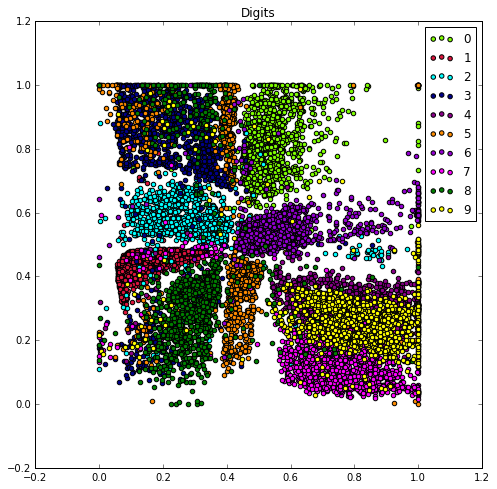

In [5]:
autoencoder.load_weights('./data-models/da-au2.chp')
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)
X_transformed = autoencoder.transform(X_test)
print(X_transformed)
colors= ["chartreuse","crimson","cyan","darkblue","darkmagenta","darkorange","darkviolet","fuchsia","green","yellow"]
# colors = plt.cm.Spectral(np.linspace(0, 1, 10))
plt.figure(figsize=(8, 8))
for c, i,target_name in zip(colors, range(10),map(lambda x:str(x),range(10))):
    plt.scatter(X_transformed[y_test == i, 0], X_transformed[y_test == i, 1],
                c=c, label=target_name)
    plt.title("Digits")
plt.legend(loc="best")


('For n_clusters =', 10, 'The average silhouette_score is :', 0.13357948)


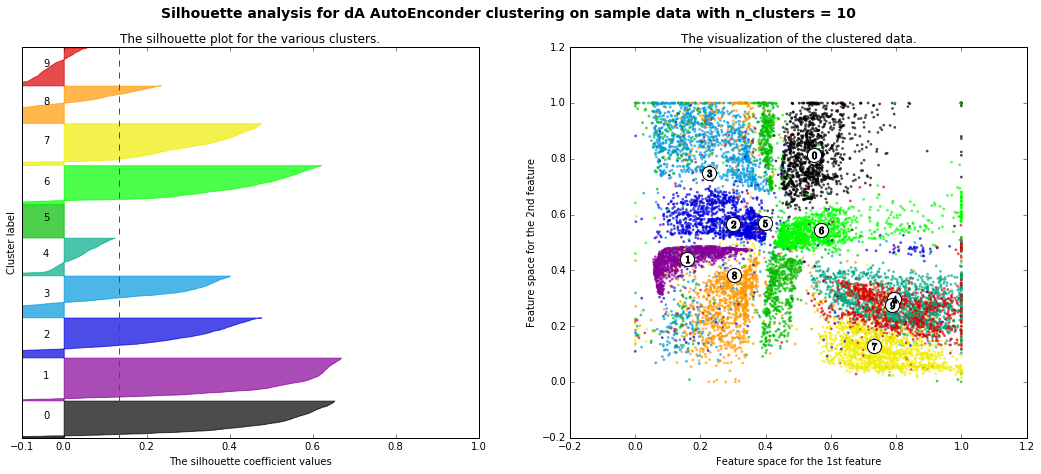

In [26]:

# Autoencoder
autoencoder = AutoEncoder(784, [1000, 500,250,2],  [['daw1', 'dahb1'],
                                                ['daw2', 'dahb2'],
                                                ['daw3', 'dahb3'],
                                                   ['daw4', 'dahb4']],
                                           tied_weights=False,keep_prob=0.9,
                                          transfer_function_enc=tf.nn.sigmoid,
                                          transfer_function_dec=tf.nn.sigmoid)
autoencoder.load_weights('./data-models/da-au2.chp')

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)
X_transformed = autoencoder.transform(X_test)
# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters

silhouette_plot.plotResult(X_transformed,y_test)


WITHOUT DROPOUT sigmoid in enc layers and sigmoid on dec layers
-------

In [6]:
from au import AutoEncoder

# Train Autoencoder
batch_size =30
epoch = 100
keep_prob_value = 1
# Autoencoder
autoencoder = AutoEncoder(784, [1000, 500,250,2],  [['daw1', 'dahb1'],
                                                ['daw2', 'dahb2'],
                                                ['daw3', 'dahb3'],
                                                   ['daw4', 'dahb4']],
                                           tied_weights=False,keep_prob=keep_prob_value,
                                          transfer_function_enc=tf.nn.sigmoid,
                                          transfer_function_dec=tf.nn.sigmoid)
# Load RBM weights to Autoencoder
autoencoder.load_da_weights('./data-models/da1.chp', ['daw1', 'dahb1'], 0)
autoencoder.load_da_weights('./data-models/da2.chp', ['daw2', 'dahb2'], 1)
autoencoder.load_da_weights('./data-models/da3.chp', ['daw3', 'dahb3'], 2)
autoencoder.load_da_weights('./data-models/da4.chp', ['daw4', 'dahb4'], 3)


interactions = int(math.floor(images.shape[0]/batch_size))
print('autoencoder')
for i in tqdm(range(epoch)):
    cost = 0.0
    for j in range(interactions):
        batch_xs, batch_ys = next_batch(j*batch_size, images,labels,batch_size)
        cost += autoencoder.partial_fit(batch_xs)
    print(i,'cost: ',cost)

autoencoder.save_weights('./data-models/da-au5.chp')


  0%|          | 0/100 [00:00<?, ?it/s]

autoencoder


  1%|          | 1/100 [00:08<14:48,  8.98s/it]

0 cost:  320.116957605


  2%|▏         | 2/100 [00:17<14:37,  8.96s/it]

1 cost:  296.923736468


  3%|▎         | 3/100 [00:26<14:27,  8.94s/it]

2 cost:  287.168555498


  4%|▍         | 4/100 [00:35<14:16,  8.93s/it]

3 cost:  280.699494466


  5%|▌         | 5/100 [00:44<14:06,  8.91s/it]

4 cost:  276.568300769


  6%|▌         | 6/100 [00:53<13:56,  8.90s/it]

5 cost:  273.890865251


  7%|▋         | 7/100 [01:02<13:46,  8.89s/it]

6 cost:  271.234366685


  8%|▊         | 8/100 [01:11<13:37,  8.89s/it]

7 cost:  269.383258015


  9%|▉         | 9/100 [01:20<13:29,  8.89s/it]

8 cost:  268.041796565


 10%|█         | 10/100 [01:28<13:19,  8.89s/it]

9 cost:  266.733734846


 11%|█         | 11/100 [01:37<13:11,  8.89s/it]

10 cost:  266.154010266


 12%|█▏        | 12/100 [01:46<13:02,  8.89s/it]

11 cost:  264.780596867


 13%|█▎        | 13/100 [01:55<12:53,  8.89s/it]

12 cost:  263.933138147


 14%|█▍        | 14/100 [02:04<12:44,  8.88s/it]

13 cost:  263.131931871


 15%|█▌        | 15/100 [02:13<12:35,  8.88s/it]

14 cost:  262.333145738


 16%|█▌        | 16/100 [02:22<12:26,  8.88s/it]

15 cost:  261.710834578


 17%|█▋        | 17/100 [02:31<12:17,  8.88s/it]

16 cost:  261.567124978


 18%|█▊        | 18/100 [02:40<12:08,  8.88s/it]

17 cost:  260.675151736


 19%|█▉        | 19/100 [02:48<11:59,  8.88s/it]

18 cost:  260.241735607


 20%|██        | 20/100 [02:57<11:50,  8.88s/it]

19 cost:  259.946972474


 21%|██        | 21/100 [03:06<11:41,  8.88s/it]

20 cost:  259.767380118


 22%|██▏       | 22/100 [03:15<11:33,  8.89s/it]

21 cost:  259.105614528


 23%|██▎       | 23/100 [03:24<11:25,  8.90s/it]

22 cost:  258.239854515


 24%|██▍       | 24/100 [03:33<11:16,  8.90s/it]

23 cost:  257.861421376


 25%|██▌       | 25/100 [03:42<11:07,  8.90s/it]

24 cost:  258.021018744


 26%|██▌       | 26/100 [03:51<10:58,  8.90s/it]

25 cost:  256.944434568


 27%|██▋       | 27/100 [04:00<10:48,  8.89s/it]

26 cost:  256.591053203


 28%|██▊       | 28/100 [04:08<10:39,  8.88s/it]

27 cost:  256.516030282


 29%|██▉       | 29/100 [04:17<10:30,  8.88s/it]

28 cost:  256.035128236


 30%|███       | 30/100 [04:26<10:20,  8.87s/it]

29 cost:  255.85370554


 31%|███       | 31/100 [04:35<10:12,  8.87s/it]

30 cost:  255.456631139


 32%|███▏      | 32/100 [04:44<10:03,  8.87s/it]

31 cost:  255.601611003


 33%|███▎      | 33/100 [04:53<09:54,  8.88s/it]

32 cost:  255.788010165


 34%|███▍      | 34/100 [05:02<09:45,  8.87s/it]

33 cost:  254.940667093


 35%|███▌      | 35/100 [05:11<09:36,  8.87s/it]

34 cost:  254.105661586


 36%|███▌      | 36/100 [05:19<09:27,  8.87s/it]

35 cost:  254.567478508


 37%|███▋      | 37/100 [05:28<09:18,  8.86s/it]

36 cost:  254.285033852


 38%|███▊      | 38/100 [05:37<09:09,  8.87s/it]

37 cost:  254.01486133


 39%|███▉      | 39/100 [05:46<09:00,  8.87s/it]

38 cost:  253.833024114


 40%|████      | 40/100 [05:55<08:51,  8.87s/it]

39 cost:  252.457226411


 41%|████      | 41/100 [06:04<08:43,  8.87s/it]

40 cost:  252.782056987


 42%|████▏     | 42/100 [06:13<08:34,  8.87s/it]

41 cost:  252.630746424


 43%|████▎     | 43/100 [06:21<08:25,  8.87s/it]

42 cost:  252.248203889


 44%|████▍     | 44/100 [06:30<08:16,  8.87s/it]

43 cost:  253.148284391


 45%|████▌     | 45/100 [06:39<08:07,  8.87s/it]

44 cost:  252.521844804


 46%|████▌     | 46/100 [06:48<07:58,  8.87s/it]

45 cost:  252.094978526


 47%|████▋     | 47/100 [06:57<07:50,  8.87s/it]

46 cost:  251.937384546


 48%|████▊     | 48/100 [07:06<07:41,  8.87s/it]

47 cost:  252.984566972


 49%|████▉     | 49/100 [07:15<07:32,  8.87s/it]

48 cost:  251.59378475


 50%|█████     | 50/100 [07:24<07:23,  8.87s/it]

49 cost:  251.668731064


 51%|█████     | 51/100 [07:32<07:14,  8.87s/it]

50 cost:  252.030924469


 52%|█████▏    | 52/100 [07:41<07:05,  8.87s/it]

51 cost:  252.14523682


 53%|█████▎    | 53/100 [07:50<06:56,  8.87s/it]

52 cost:  251.764973626


 54%|█████▍    | 54/100 [07:59<06:47,  8.86s/it]

53 cost:  251.390191332


 55%|█████▌    | 55/100 [08:08<06:38,  8.86s/it]

54 cost:  250.509865507


 56%|█████▌    | 56/100 [08:17<06:29,  8.85s/it]

55 cost:  250.859989628


 57%|█████▋    | 57/100 [08:26<06:20,  8.85s/it]

56 cost:  250.490773961


 58%|█████▊    | 58/100 [08:34<06:11,  8.84s/it]

57 cost:  250.722062469


 59%|█████▉    | 59/100 [08:43<06:02,  8.84s/it]

58 cost:  251.372769848


 60%|██████    | 60/100 [08:52<05:53,  8.84s/it]

59 cost:  251.386913911


 61%|██████    | 61/100 [09:01<05:44,  8.84s/it]

60 cost:  250.99369286


 62%|██████▏   | 62/100 [09:10<05:35,  8.83s/it]

61 cost:  250.237678245


 63%|██████▎   | 63/100 [09:19<05:26,  8.83s/it]

62 cost:  250.068793103


 64%|██████▍   | 64/100 [09:27<05:18,  8.84s/it]

63 cost:  249.427242026


 65%|██████▌   | 65/100 [09:36<05:09,  8.84s/it]

64 cost:  248.884629503


 66%|██████▌   | 66/100 [09:45<05:00,  8.84s/it]

65 cost:  248.753392398


 67%|██████▋   | 67/100 [09:54<04:51,  8.84s/it]

66 cost:  248.440842301


 68%|██████▊   | 68/100 [10:03<04:42,  8.84s/it]

67 cost:  249.324831903


 69%|██████▉   | 69/100 [10:12<04:34,  8.84s/it]

68 cost:  249.728562847


 70%|███████   | 70/100 [10:20<04:25,  8.84s/it]

69 cost:  249.708061665


 71%|███████   | 71/100 [10:29<04:16,  8.84s/it]

70 cost:  249.327044487


 72%|███████▏  | 72/100 [10:38<04:07,  8.84s/it]

71 cost:  249.397548705


 73%|███████▎  | 73/100 [10:47<03:58,  8.83s/it]

72 cost:  249.577424645


 74%|███████▍  | 74/100 [10:56<03:49,  8.83s/it]

73 cost:  248.137497336


 75%|███████▌  | 75/100 [11:05<03:40,  8.84s/it]

74 cost:  247.49153094


 76%|███████▌  | 76/100 [11:13<03:32,  8.84s/it]

75 cost:  247.293832392


 77%|███████▋  | 77/100 [11:22<03:23,  8.84s/it]

76 cost:  247.600960612


 78%|███████▊  | 78/100 [11:31<03:14,  8.84s/it]

77 cost:  248.194606811


 79%|███████▉  | 79/100 [11:40<03:05,  8.84s/it]

78 cost:  247.940376595


 80%|████████  | 80/100 [11:49<02:56,  8.84s/it]

79 cost:  248.395384893


 81%|████████  | 81/100 [11:58<02:47,  8.84s/it]

80 cost:  248.83106856


 82%|████████▏ | 82/100 [12:06<02:39,  8.84s/it]

81 cost:  248.922550872


 83%|████████▎ | 83/100 [12:15<02:30,  8.83s/it]

82 cost:  248.317776635


 84%|████████▍ | 84/100 [12:24<02:21,  8.83s/it]

83 cost:  246.656034559


 85%|████████▌ | 85/100 [12:33<02:12,  8.84s/it]

84 cost:  246.714143515


 86%|████████▌ | 86/100 [12:42<02:03,  8.84s/it]

85 cost:  247.299398139


 87%|████████▋ | 87/100 [12:51<01:54,  8.84s/it]

86 cost:  246.435963944


 88%|████████▊ | 88/100 [12:59<01:46,  8.84s/it]

87 cost:  246.548240498


 89%|████████▉ | 89/100 [13:08<01:37,  8.85s/it]

88 cost:  247.241670892


 90%|█████████ | 90/100 [13:17<01:28,  8.85s/it]

89 cost:  247.809425071


 91%|█████████ | 91/100 [13:26<01:19,  8.85s/it]

90 cost:  248.775565401


 92%|█████████▏| 92/100 [13:35<01:10,  8.85s/it]

91 cost:  247.444316611


 93%|█████████▎| 93/100 [13:44<01:01,  8.85s/it]

92 cost:  247.442214206


 94%|█████████▍| 94/100 [13:53<00:53,  8.85s/it]

93 cost:  246.054880515


 95%|█████████▌| 95/100 [14:01<00:44,  8.86s/it]

94 cost:  246.286837772


 96%|█████████▌| 96/100 [14:10<00:35,  8.85s/it]

95 cost:  246.343110695


 97%|█████████▋| 97/100 [14:19<00:26,  8.86s/it]

96 cost:  247.065741226


 98%|█████████▊| 98/100 [14:28<00:17,  8.86s/it]

97 cost:  246.440665573


 99%|█████████▉| 99/100 [14:37<00:08,  8.86s/it]

98 cost:  245.931876078


100%|██████████| 100/100 [14:46<00:00,  8.86s/it]

99 cost:  246.853684023


[[ 0.17555171  0.61508781]
 [ 0.12077688  0.08176272]
 [ 0.58219761  0.10481486]
 ..., 
 [ 0.18737687  0.23049086]
 [ 0.5364247   0.75721765]
 [ 0.65003043  0.98579061]]


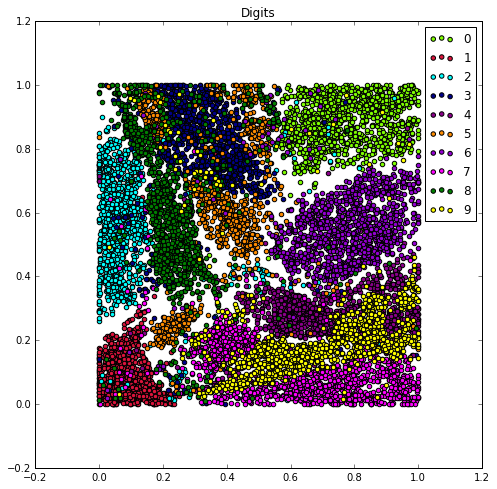

In [7]:
from sklearn.cross_validation import train_test_split
autoencoder.load_weights('./data-models/da-au5.chp')
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)
X_transformed = autoencoder.transform(X_test)
print(X_transformed)
colors= ["chartreuse","crimson","cyan","darkblue","darkmagenta","darkorange","darkviolet","fuchsia","green","yellow"]
plt.figure(figsize=(8, 8))
for c, i,target_name in zip(colors, range(10),map(lambda x:str(x),range(10))):
    plt.scatter(X_transformed[y_test == i, 0], X_transformed[y_test == i, 1],
                c=c, label=target_name)
    plt.title("Digits")
plt.legend(loc="best")


('For n_clusters =', 10, 'The average silhouette_score is :', 0.18687527)


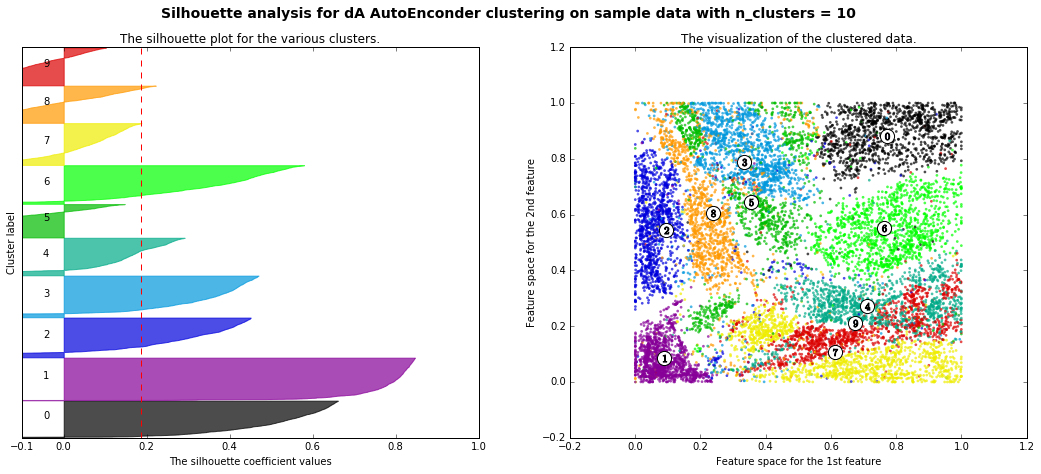

In [28]:

# Autoencoder

autoencoder = AutoEncoder(784, [1000, 500,250,2],  [['daw1', 'dahb1'],
                                                ['daw2', 'dahb2'],
                                                ['daw3', 'dahb3'],
                                                   ['daw4', 'dahb4']],
                                           tied_weights=False,keep_prob=1,
                                          transfer_function_enc=tf.nn.sigmoid,
                                          transfer_function_dec=tf.nn.sigmoid)
autoencoder.load_weights('./data-models/da-au5.chp')

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)
X_transformed = autoencoder.transform(X_test)
# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters

silhouette_plot.plotResult(X_transformed,y_test)


WITHOUT DROPOUT relu in enc layers and sigmoid on dec layers and L1 Regularization
-------

In [8]:
from au import AutoEncoder

# Train Autoencoder
batch_size =30
epoch = 100
keep_prob_value = 1
# Autoencoder
autoencoder = AutoEncoder(784, [1000, 500,250,2],  [['daw1', 'dahb1'],
                                                ['daw2', 'dahb2'],
                                                ['daw3', 'dahb3'],
                                                   ['daw4', 'dahb4']],
                                         tied_weights=False,keep_prob=keep_prob_value,regtype='l1')
                          
# Load RBM weights to Autoencoder
autoencoder.load_da_weights('./data-models/da1.chp', ['daw1', 'dahb1'], 0)
autoencoder.load_da_weights('./data-models/da2.chp', ['daw2', 'dahb2'], 1)
autoencoder.load_da_weights('./data-models/da3.chp', ['daw3', 'dahb3'], 2)
autoencoder.load_da_weights('./data-models/da4.chp', ['daw4', 'dahb4'], 3)

interactions = int(math.floor(images.shape[0]/batch_size))
print('autoencoder')
for i in tqdm(range(epoch)):
    cost = 0.0
    for j in range(interactions):
        batch_xs, batch_ys = next_batch(j*batch_size, images,labels,batch_size)
        cost += autoencoder.partial_fit(batch_xs)
    print(i,'cost: ',cost)

autoencoder.save_weights('./data-models/da-au9.chp')



  0%|          | 0/100 [00:00<?, ?it/s]

autoencoder


  1%|          | 1/100 [00:10<17:05, 10.36s/it]

0 cost:  2665.93646678


  2%|▏         | 2/100 [00:20<16:54, 10.35s/it]

1 cost:  440.509270668


  3%|▎         | 3/100 [00:31<16:43, 10.34s/it]

2 cost:  435.453746527


  4%|▍         | 4/100 [00:41<16:32, 10.34s/it]

3 cost:  432.967511773


  5%|▌         | 5/100 [00:51<16:22, 10.34s/it]

4 cost:  431.185657114


  6%|▌         | 6/100 [01:02<16:11, 10.34s/it]

5 cost:  429.816157192


  7%|▋         | 7/100 [01:12<16:00, 10.33s/it]

6 cost:  428.840001494


  8%|▊         | 8/100 [01:22<15:50, 10.33s/it]

7 cost:  428.240866303


  9%|▉         | 9/100 [01:33<15:40, 10.33s/it]

8 cost:  427.749626696


 10%|█         | 10/100 [01:43<15:29, 10.33s/it]

9 cost:  427.309578091


 11%|█         | 11/100 [01:53<15:19, 10.33s/it]

10 cost:  426.974615842


 12%|█▏        | 12/100 [02:03<15:07, 10.31s/it]

11 cost:  426.782034934


 13%|█▎        | 13/100 [02:14<14:57, 10.32s/it]

12 cost:  426.625424802


 14%|█▍        | 14/100 [02:24<14:47, 10.32s/it]

13 cost:  426.514400721


 15%|█▌        | 15/100 [02:34<14:37, 10.33s/it]

14 cost:  426.402419031


 16%|█▌        | 16/100 [02:45<14:27, 10.33s/it]

15 cost:  426.301694512


 17%|█▋        | 17/100 [02:55<14:17, 10.33s/it]

16 cost:  426.208291203


 18%|█▊        | 18/100 [03:05<14:06, 10.33s/it]

17 cost:  426.112633377


 19%|█▉        | 19/100 [03:16<13:56, 10.32s/it]

18 cost:  425.972271949


 20%|██        | 20/100 [03:26<13:45, 10.32s/it]

19 cost:  425.807469994


 21%|██        | 21/100 [03:36<13:36, 10.33s/it]

20 cost:  425.715602994


 22%|██▏       | 22/100 [03:47<13:26, 10.34s/it]

21 cost:  425.614304781


 23%|██▎       | 23/100 [03:57<13:15, 10.34s/it]

22 cost:  425.572193265


 24%|██▍       | 24/100 [04:07<13:06, 10.35s/it]

23 cost:  425.471592814


 25%|██▌       | 25/100 [04:18<12:56, 10.35s/it]

24 cost:  425.365058124


 26%|██▌       | 26/100 [04:28<12:45, 10.34s/it]

25 cost:  425.301498771


 27%|██▋       | 27/100 [04:39<12:35, 10.35s/it]

26 cost:  425.220620632


 28%|██▊       | 28/100 [04:49<12:25, 10.35s/it]

27 cost:  425.167626292


 29%|██▉       | 29/100 [04:59<12:14, 10.35s/it]

28 cost:  425.086969554


 30%|███       | 30/100 [05:10<12:04, 10.35s/it]

29 cost:  425.028096408


 31%|███       | 31/100 [05:20<11:53, 10.34s/it]

30 cost:  424.966310382


 32%|███▏      | 32/100 [05:30<11:42, 10.34s/it]

31 cost:  424.908496141


 33%|███▎      | 33/100 [05:41<11:33, 10.34s/it]

32 cost:  424.868552148


 34%|███▍      | 34/100 [05:51<11:22, 10.35s/it]

33 cost:  424.820087284


 35%|███▌      | 35/100 [06:01<11:12, 10.34s/it]

34 cost:  424.781178862


 36%|███▌      | 36/100 [06:12<11:01, 10.34s/it]

35 cost:  424.745280802


 37%|███▋      | 37/100 [06:22<10:51, 10.34s/it]

36 cost:  424.715681791


 38%|███▊      | 38/100 [06:32<10:41, 10.34s/it]

37 cost:  424.688715547


 39%|███▉      | 39/100 [06:43<10:30, 10.34s/it]

38 cost:  424.640413135


 40%|████      | 40/100 [06:53<10:20, 10.35s/it]

39 cost:  424.598110914


 41%|████      | 41/100 [07:03<10:10, 10.34s/it]

40 cost:  424.559836239


 42%|████▏     | 42/100 [07:14<10:00, 10.35s/it]

41 cost:  424.563711077


 43%|████▎     | 43/100 [07:24<09:49, 10.35s/it]

42 cost:  424.548675239


 44%|████▍     | 44/100 [07:34<09:39, 10.35s/it]

43 cost:  424.501207054


 45%|████▌     | 45/100 [07:45<09:29, 10.36s/it]

44 cost:  424.450788766


 46%|████▌     | 46/100 [07:55<09:19, 10.36s/it]

45 cost:  424.425721318


 47%|████▋     | 47/100 [08:05<09:08, 10.36s/it]

46 cost:  424.391662806


 48%|████▊     | 48/100 [08:16<08:58, 10.35s/it]

47 cost:  424.344487876


 49%|████▉     | 49/100 [08:26<08:48, 10.36s/it]

48 cost:  424.3434183


 50%|█████     | 50/100 [08:37<08:37, 10.36s/it]

49 cost:  424.315655857


 51%|█████     | 51/100 [08:47<08:27, 10.35s/it]

50 cost:  424.281596243


 52%|█████▏    | 52/100 [08:57<08:16, 10.35s/it]

51 cost:  424.252827287


 53%|█████▎    | 53/100 [09:08<08:06, 10.35s/it]

52 cost:  424.246048868


 54%|█████▍    | 54/100 [09:18<07:56, 10.35s/it]

53 cost:  424.234544128


 55%|█████▌    | 55/100 [09:28<07:45, 10.35s/it]

54 cost:  424.225359231


 56%|█████▌    | 56/100 [09:39<07:35, 10.35s/it]

55 cost:  424.227211326


 57%|█████▋    | 57/100 [09:49<07:24, 10.35s/it]

56 cost:  424.182012588


 58%|█████▊    | 58/100 [09:59<07:14, 10.35s/it]

57 cost:  424.176807135


 59%|█████▉    | 59/100 [10:10<07:04, 10.34s/it]

58 cost:  424.153315574


 60%|██████    | 60/100 [10:20<06:53, 10.34s/it]

59 cost:  424.106821597


 61%|██████    | 61/100 [10:30<06:43, 10.35s/it]

60 cost:  424.086261183


 62%|██████▏   | 62/100 [10:41<06:33, 10.35s/it]

61 cost:  424.0656434


 63%|██████▎   | 63/100 [10:51<06:23, 10.35s/it]

62 cost:  424.051926196


 64%|██████▍   | 64/100 [11:01<06:12, 10.34s/it]

63 cost:  424.027809024


 65%|██████▌   | 65/100 [11:12<06:02, 10.35s/it]

64 cost:  424.011811554


 66%|██████▌   | 66/100 [11:22<05:51, 10.35s/it]

65 cost:  423.959173113


 67%|██████▋   | 67/100 [11:32<05:41, 10.35s/it]

66 cost:  423.955485463


 68%|██████▊   | 68/100 [11:43<05:31, 10.35s/it]

67 cost:  423.925277799


 69%|██████▉   | 69/100 [11:53<05:20, 10.35s/it]

68 cost:  423.886589527


 70%|███████   | 70/100 [12:04<05:10, 10.35s/it]

69 cost:  423.864707291


 71%|███████   | 71/100 [12:14<05:00, 10.35s/it]

70 cost:  423.825224042


 72%|███████▏  | 72/100 [12:24<04:49, 10.35s/it]

71 cost:  423.826181889


 73%|███████▎  | 73/100 [12:35<04:39, 10.35s/it]

72 cost:  423.812800139


 74%|███████▍  | 74/100 [12:45<04:29, 10.35s/it]

73 cost:  423.807704598


 75%|███████▌  | 75/100 [12:55<04:18, 10.35s/it]

74 cost:  423.786362886


 76%|███████▌  | 76/100 [13:06<04:08, 10.35s/it]

75 cost:  423.811804801


 77%|███████▋  | 77/100 [13:16<03:57, 10.34s/it]

76 cost:  423.735360652


 78%|███████▊  | 78/100 [13:26<03:47, 10.35s/it]

77 cost:  423.766251147


 79%|███████▉  | 79/100 [13:37<03:37, 10.36s/it]

78 cost:  423.773260206


 80%|████████  | 80/100 [13:47<03:27, 10.36s/it]

79 cost:  423.751958251


 81%|████████  | 81/100 [13:57<03:16, 10.37s/it]

80 cost:  423.786589563


 82%|████████▏ | 82/100 [14:08<03:06, 10.37s/it]

81 cost:  423.8126854


 83%|████████▎ | 83/100 [14:18<02:56, 10.36s/it]

82 cost:  423.760621637


 84%|████████▍ | 84/100 [14:29<02:45, 10.36s/it]

83 cost:  423.760832757


 85%|████████▌ | 85/100 [14:39<02:35, 10.36s/it]

84 cost:  423.759938151


 86%|████████▌ | 86/100 [14:49<02:25, 10.36s/it]

85 cost:  423.769509196


 87%|████████▋ | 87/100 [15:00<02:14, 10.36s/it]

86 cost:  423.763871163


 88%|████████▊ | 88/100 [15:10<02:04, 10.35s/it]

87 cost:  423.747826636


 89%|████████▉ | 89/100 [15:20<01:53, 10.36s/it]

88 cost:  423.740585238


 90%|█████████ | 90/100 [15:31<01:43, 10.35s/it]

89 cost:  423.853011101


 91%|█████████ | 91/100 [15:41<01:33, 10.35s/it]

90 cost:  423.938271344


 92%|█████████▏| 92/100 [15:51<01:22, 10.35s/it]

91 cost:  423.938240528


 93%|█████████▎| 93/100 [16:02<01:12, 10.36s/it]

92 cost:  423.976146191


 94%|█████████▍| 94/100 [16:12<01:02, 10.35s/it]

93 cost:  424.01040706


 95%|█████████▌| 95/100 [16:22<00:51, 10.36s/it]

94 cost:  424.007721186


 96%|█████████▌| 96/100 [16:33<00:41, 10.36s/it]

95 cost:  424.011213064


 97%|█████████▋| 97/100 [16:43<00:31, 10.35s/it]

96 cost:  423.961672217


 98%|█████████▊| 98/100 [16:53<00:20, 10.35s/it]

97 cost:  423.948092252


 99%|█████████▉| 99/100 [17:04<00:10, 10.36s/it]

98 cost:  423.862796396


100%|██████████| 100/100 [17:14<00:00, 10.36s/it]

99 cost:  423.84636572


[[ 0.04024032  0.2464072 ]
 [ 0.00611292  0.21387303]
 [ 0.07462876  0.05385039]
 ..., 
 [ 0.05100913  0.1992103 ]
 [ 0.13596246  0.27733442]
 [ 0.17716463  0.36902097]]


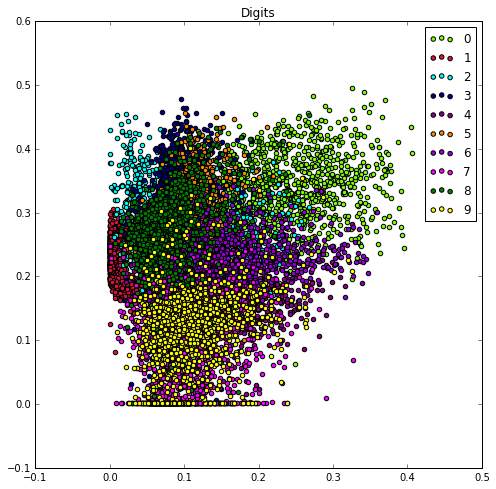

In [9]:
from sklearn.cross_validation import train_test_split
autoencoder.load_weights('./data-models/da-au9.chp')
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)
X_transformed = autoencoder.transform(X_test)
print(X_transformed)
colors= ["chartreuse","crimson","cyan","darkblue","darkmagenta","darkorange","darkviolet","fuchsia","green","yellow"]
plt.figure(figsize=(8, 8))
for c, i,target_name in zip(colors, range(10),map(lambda x:str(x),range(10))):
    plt.scatter(X_transformed[y_test == i, 0], X_transformed[y_test == i, 1],
                c=c, label=target_name)
    plt.title("Digits")
plt.legend(loc="best")

('For n_clusters =', 10, 'The average silhouette_score is :', 0.008103352)


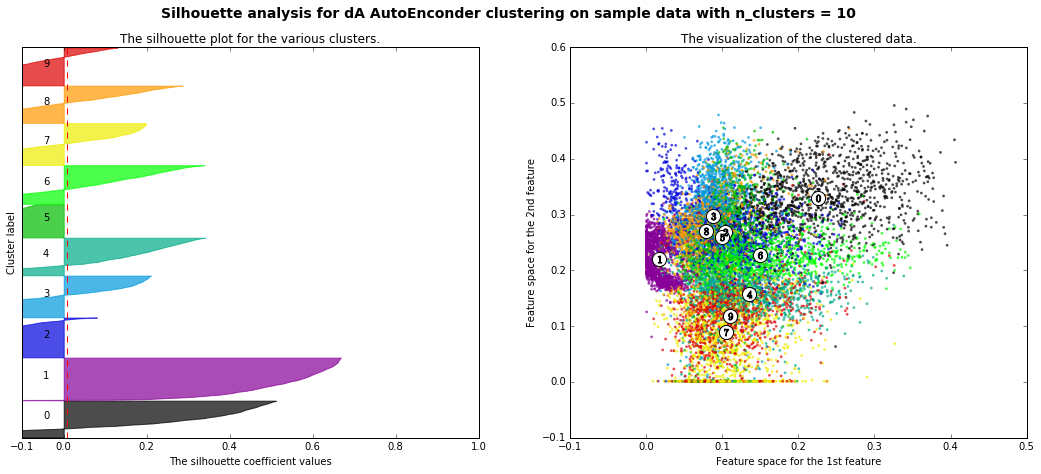

In [29]:

keep_prob_value = 1
# Autoencoder
autoencoder = AutoEncoder(784, [1000, 500,250,2],  [['daw1', 'dahb1'],
                                                ['daw2', 'dahb2'],
                                                ['daw3', 'dahb3'],
                                                   ['daw4', 'dahb4']],
                                         tied_weights=False,keep_prob=keep_prob_value,regtype='l1')
autoencoder.load_weights('./data-models/da-au9.chp')

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)
X_transformed = autoencoder.transform(X_test)
# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters

silhouette_plot.plotResult(X_transformed,y_test)


PCA
-----

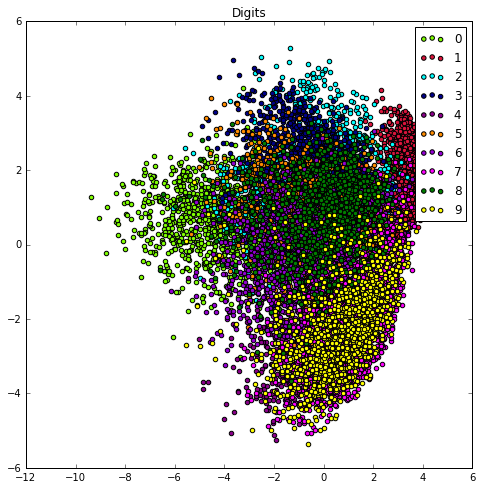

In [30]:
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)
pca = PCA(n_components=3).fit(X_train)
X_transformed = pca.transform(X_test)

colors= ["chartreuse","crimson","cyan","darkblue","darkmagenta","darkorange","darkviolet","fuchsia","green","yellow"]
plt.figure(figsize=(8, 8))
for c, i,target_name in zip(colors, range(10),map(lambda x:str(x),range(10))):
    plt.scatter(X_transformed[y_test == i, 0], X_transformed[y_test == i, 1],
                c=c, label=target_name)
    plt.title("Digits")
plt.legend(loc="best")


('For n_clusters =', 10, 'The average silhouette_score is :', 0.026255409371306025)


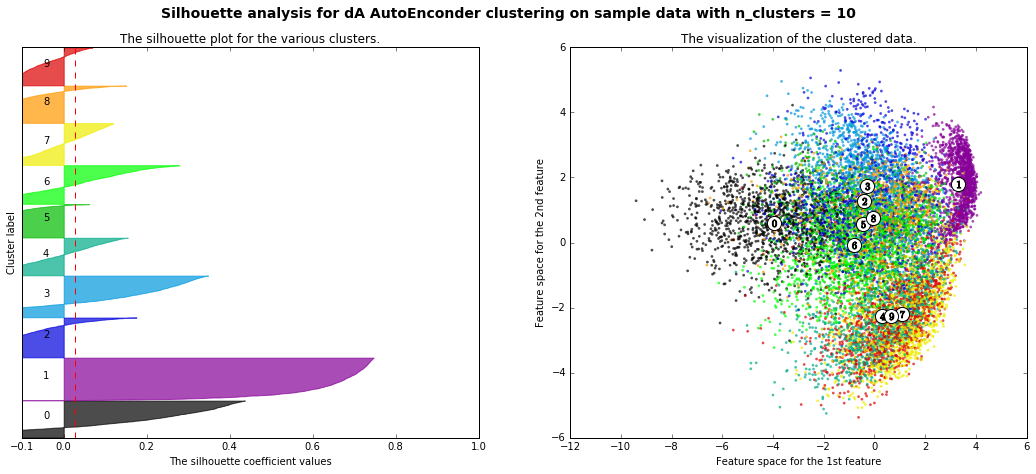

In [31]:

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)
X_transformed = pca.transform(X_test)
# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters

silhouette_plot.plotResult(X_transformed,y_test)
